# Training models

## 1. Importing libraries

In [1]:
#Import libraries
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import numpy as np
from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.callbacks import ModelCheckpoint
from keras import backend

from sklearn.metrics import r2_score

Using TensorFlow backend.


## 2. Importing and preparing the dataset

### Importing

In [94]:
textureimages = np.load('textureimagequality20.npy') # Images with 20% pixel size
texturedata   = pd.read_csv('texturedataprepared.csv') # Texture index data

### Data augmentation

Rotate the images 180 degree and keep the same texture index as the original image.

In [95]:
texturedata = texturedata.append(texturedata)
textureimages = np.append(textureimages,np.rot90(textureimages,4,axes=(1,0)),axis=0)

### Divide the dataset in trainning set, validation set and test set

In [96]:
x_train = textureimages[:].astype('float32')/255 # Data normalization
y_train = texturedata['texture'][:].values

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

train_size, length, height, channels = x_train.shape

### Create function of *R-squared* metric to be used by the models

In [34]:
def rsquared(y_true, y_pred):
    residuals     =  backend.sum(backend.square(y_true - y_pred)) 
    mean_residual = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return (1 - residuals/(mean_residual))

## 3. Trainning and Evaluating Models

### 3.1 Vanilla Neural Network

Train the data in a simple neural network to use as baseline for further assessment.

In [35]:
model = Sequential()
model.add(Flatten(input_shape = x_train.shape[1:]))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1000)              49153000  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1001      
Total params: 49,154,001
Trainable params: 49,154,001
Non-trainable params: 0
_________________________________________________________________


In [36]:
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[rsquared])

checkpointer = ModelCheckpoint(filepath='model.weights.vanilla.hdf5', verbose=1, 
                               save_best_only=True)

In [13]:
hist = model.fit(x_train, y_train, batch_size=30, epochs=20,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 1820 samples, validate on 455 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 95601.18261, saving model to model.weights.vanilla.hdf5
35s - loss: 101269.3158 - rsquared: -2.3691e-01 - val_loss: 95601.1826 - val_rsquared: -9.4638e-02
Epoch 2/20
Epoch 00001: val_loss improved from 95601.18261 to 95455.83851, saving model to model.weights.vanilla.hdf5
41s - loss: 91164.5915 - rsquared: -1.3527e-01 - val_loss: 95455.8385 - val_rsquared: -6.6544e-02
Epoch 3/20
Epoch 00002: val_loss did not improve
37s - loss: 88478.7595 - rsquared: -6.3014e-02 - val_loss: 97321.2374 - val_rsquared: -7.9394e-02
Epoch 4/20
Epoch 00003: val_loss did not improve
35s - loss: 92711.0504 - rsquared: -1.6098e-01 - val_loss: 98615.2568 - val_rsquared: -9.0852e-02
Epoch 5/20
Epoch 00004: val_loss did not improve
37s - loss: 87480.6150 - rsquared: -5.4899e-02 - val_loss: 97516.7025 - val_rsquared: -8.0829e-02
Epoch 6/20
Epoch 00005: val_loss did not improve
40s - loss: 87910.3261 - rsquared: -6.

In [37]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.vanilla.hdf5')

Evaluating the model according to the established metrics.

In [38]:
y_hat = model.predict(x_test) # Model prediction
r2_vanilla = r2_score(y_test,y_hat) # R-squared

y_test = y_test.reshape((y_test.shape[0],1)) # Adjust shape of array

residual = y_test - y_hat # Calculating the residuals from the real and the predicted
mae_vanilla      = np.mean((residual**2)**0.5) # Calculating the Mean Absolute Error

print("R-Squared = ", r2_vanilla)
print("MAE       = ", mae_vanilla)

R-Squared =  0.0300060859605
MAE       =  235.669926187


Test set average   =  495.358699473
Prediction average =  499.508


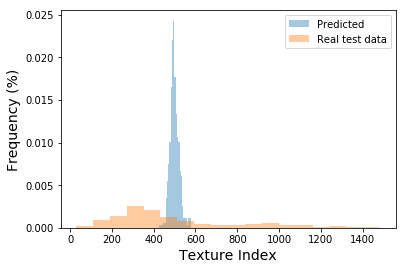

In [43]:
# Visualizing the prediction distribution and the test set distribution
sns.distplot(y_hat,kde=False,norm_hist=True, label='Predicted')
sns.distplot(y_test,kde=False,norm_hist=True,label='Real test data')
plt.xlabel("Texture Index",size=14)
plt.ylabel("Frequency (%)",size=14)
plt.legend()
print("Test set average   = ",np.average(y_test))
print("Prediction average = ",np.average(y_hat))
plt.savefig('BaselineModelDistributionResults.png')

As can be seen, the Vanilla Neural Network model doesn't perform very well. What it does is predict that the texture will be around the average value of the whole data.

### 3.2 Best CNN Model

The original architecture used for the CNN was from https://github.com/udacity/aind2-cnn/blob/master/cifar10-classification/cifar10_mlp.ipynb.

Based on this initial model, several CNN architectures were tested. The models were assessed in terms of R-Squared metric and Mean Absolute Error. The model that gave the best results consisted in adding two more *Dense Layers* and decreasing the *Dropout* probability to 0.2.

In [97]:
model = Sequential()
model.add(Conv2D(filters=int(length/2), kernel_size=2, padding='same', activation='relu', 
                        input_shape=(length, height,channels)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length*2, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1000, activation='relu')) # Added
model.add(Dense(1000, activation='relu')) # Added
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 96, 128, 48)       816       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 48, 64, 48)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 64, 96)        18528     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 24, 32, 96)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 32, 192)       73920     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 16, 192)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 16, 192)       0         
__________

In [98]:
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[rsquared])

checkpointer = ModelCheckpoint(filepath='model.weights.cnn.hdf5', verbose=1, 
                               save_best_only=True)



In [8]:
hist = model.fit(x_train, y_train, batch_size=30, epochs=20,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 1820 samples, validate on 455 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 82312.17067, saving model to model.weights.cnn.hdf5
12s - loss: 118895.7236 - rsquared: -4.6486e-01 - val_loss: 82312.1707 - val_rsquared: 0.0886
Epoch 2/20
Epoch 00001: val_loss improved from 82312.17067 to 34931.65048, saving model to model.weights.cnn.hdf5
11s - loss: 58522.3080 - rsquared: 0.2941 - val_loss: 34931.6505 - val_rsquared: 0.6172
Epoch 3/20
Epoch 00002: val_loss improved from 34931.65048 to 17105.92042, saving model to model.weights.cnn.hdf5
11s - loss: 13184.2611 - rsquared: 0.8299 - val_loss: 17105.9204 - val_rsquared: 0.7982
Epoch 4/20
Epoch 00003: val_loss improved from 17105.92042 to 2174.28658, saving model to model.weights.cnn.hdf5
11s - loss: 5408.4255 - rsquared: 0.9329 - val_loss: 2174.2866 - val_rsquared: 0.9735
Epoch 5/20
Epoch 00004: val_loss improved from 2174.28658 to 1459.80033, saving model to model.weights.cnn.hdf5
11s - loss: 2877.3261 - rsquared: 0.96

In [99]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.cnn.hdf5')

In [100]:
y_hat = model.predict(x_test) # Model prediction
r2_vanilla = r2_score(y_test,y_hat) # R-squared

y_test = y_test.reshape((y_test.shape[0],1)) # Adjust shape of array

residual = y_test - y_hat # Calculating the residuals from the real and the predicted
mae_vanilla      = np.mean((residual**2)**0.5) # Calculating the Mean Absolute Error

print("R-Squared = ", r2_vanilla)
print("MAE       = ", mae_vanilla)

R-Squared =  0.993795848736
MAE       =  18.2847223225


Test set average   =  495.358699473
Prediction average =  485.9


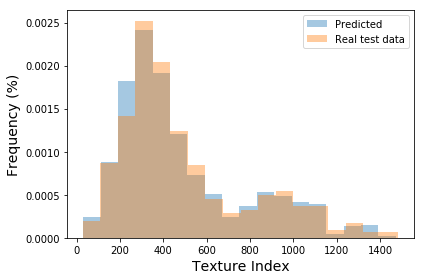

In [104]:
# Visualizing the prediction distribution and the test set distribution
sns.distplot(y_hat,kde=False,norm_hist=True, label='Predicted')
sns.distplot(y_test,kde=False,norm_hist=True,label='Real test data')
plt.xlabel("Texture Index",size=14)
plt.ylabel("Frequency (%)",size=14)
plt.legend()
print("Test set average   = ",np.average(y_test))
print("Prediction average = ",np.average(y_hat))
plt.tight_layout()
plt.savefig('CNN20ModelDistributionResults.png')

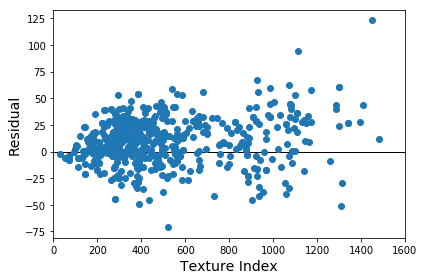

In [114]:
# Plotting the residuals to analyze the distribution of the MAE
plt.plot(y_test,residual,'o')
plt.xlim(0,1600)
plt.xlabel("Texture Index",size=14)
plt.ylabel("Residual",size=14)
plt.hlines(0,xmin=-200,xmax=1600,linewidth=1)
plt.tight_layout()
plt.savefig("Residuals-plot.png")

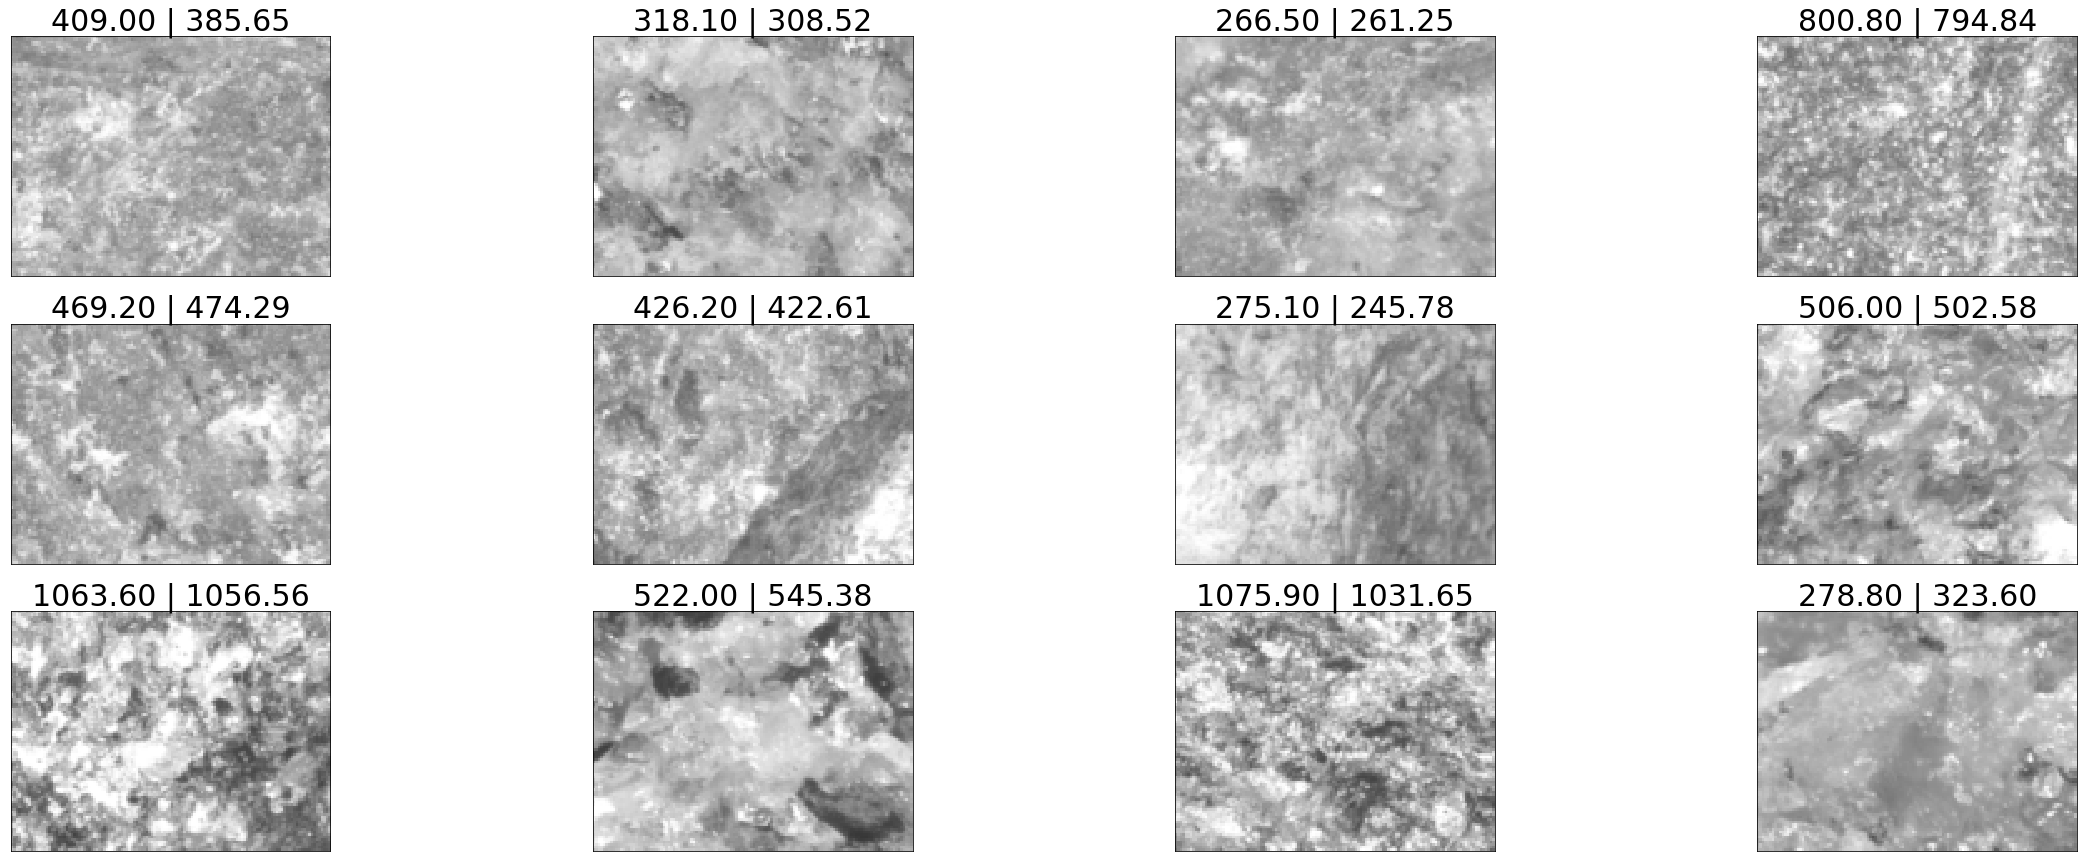

In [157]:
# Visualizing the data

fig = plt.figure(figsize=(40,15))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow((x_test[i]))
    real = y_test[i]
    predicted = y_hat[i]
    ax.set_title("{:.2f} | {:.2f}".format(real[0],predicted[0]),fontsize=30)
    


## 4. lmage Quality impact evaluation

### 4.1 Lower image resolution

The images will be reduced to only 10% of the original pixel size.

In [15]:
textureimages = np.load('textureimagequality10.npy') # Images with 10% pixel size
texturedata   = pd.read_csv('texturedataprepared.csv') # Texture index data
texturedata = texturedata.append(texturedata)
textureimages = np.append(textureimages,np.rot90(textureimages,4,axes=(1,0)),axis=0)

In [16]:
x_train = textureimages[:].astype('float32')/255
y_train = texturedata['texture'][:].values

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

train_size, length, height, channels = x_train.shape

In [17]:
model = Sequential()
model.add(Conv2D(filters=int(length/2), kernel_size=2, padding='same', activation='relu', 
                        input_shape=(length, height,channels)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length*2, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1000, activation='relu')) # Added
model.add(Dense(1000, activation='relu')) # Added
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 64, 24)        408       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 32, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 32, 48)        4656      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 16, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 16, 96)        18528     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 8, 96)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 8, 96)          0         
__________

In [11]:
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[rsquared])

checkpointer = ModelCheckpoint(filepath='model.weights.cnn10.hdf5', verbose=1, 
                               save_best_only=True)

In [12]:
hist = model.fit(x_train, y_train, batch_size=30, epochs=20,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 1820 samples, validate on 455 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 77076.29026, saving model to model.weights.cnn10.hdf5
2s - loss: 106168.7437 - rsquared: -2.8913e-01 - val_loss: 77076.2903 - val_rsquared: 0.1563
Epoch 2/20
Epoch 00001: val_loss improved from 77076.29026 to 38810.79031, saving model to model.weights.cnn10.hdf5
2s - loss: 50442.5488 - rsquared: 0.3556 - val_loss: 38810.7903 - val_rsquared: 0.5161
Epoch 3/20
Epoch 00002: val_loss improved from 38810.79031 to 12913.02890, saving model to model.weights.cnn10.hdf5
2s - loss: 25144.7274 - rsquared: 0.6758 - val_loss: 12913.0289 - val_rsquared: 0.8411
Epoch 4/20
Epoch 00003: val_loss improved from 12913.02890 to 11472.62552, saving model to model.weights.cnn10.hdf5
2s - loss: 11996.3974 - rsquared: 0.8494 - val_loss: 11472.6255 - val_rsquared: 0.8684
Epoch 5/20
Epoch 00004: val_loss did not improve
1s - loss: 13448.1367 - rsquared: 0.8232 - val_loss: 11614.4630 - val_rsquared: 0.8676
Epoch 6

In [18]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.cnn10.hdf5')

In [19]:
y_hat = model.predict(x_test) # Model prediction
r2_vanilla = r2_score(y_test,y_hat) # R-squared

y_test = y_test.reshape((y_test.shape[0],1)) # Adjust shape of array

residual = y_test - y_hat # Calculating the residuals from the real and the predicted
mae_vanilla      = np.mean((residual**2)**0.5) # Calculating the Mean Absolute Error

print("R-Squared = ", r2_vanilla)
print("MAE       = ", mae_vanilla)

R-Squared =  0.974668211139
MAE       =  35.0329371206


Test set average   =  495.358699473
Prediction average =  490.689


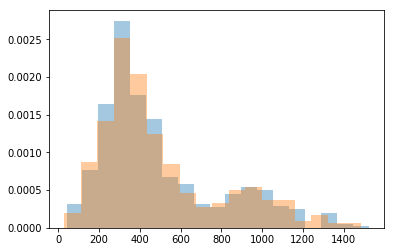

In [20]:
# Visualizing the prediction distribution and the test set distribution
sns.distplot(y_hat,kde=False,norm_hist=True)
sns.distplot(y_test,kde=False,norm_hist=True)
print("Test set average   = ",np.average(y_test))
print("Prediction average = ",np.average(y_hat))

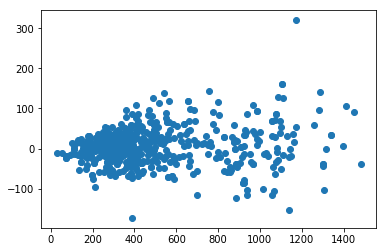

In [22]:
# Plotting the residuals to analyze the distribution of the MAE
plt.plot(y_test,residual,'o')

### 4.2 Higher image resolution

The images will be reduced to 30% of the original pixel size, which is higher then the 20% which was originaly used.

In [50]:
textureimages = np.load('textureimagequality30.npy') # Images with 10% pixel size
texturedata   = pd.read_csv('texturedataprepared.csv') # Texture index data
texturedata = texturedata.append(texturedata)
textureimages = np.append(textureimages,np.rot90(textureimages,4,axes=(1,0)),axis=0)

In [51]:
x_train = textureimages[:].astype('float32')/255
y_train = texturedata['texture'][:].values

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

train_size, length, height, channels = x_train.shape

In [52]:
model = Sequential()
model.add(Conv2D(filters=int(length/2), kernel_size=2, padding='same', activation='relu', 
                        input_shape=(length, height,channels)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length*2, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1000, activation='relu')) # Added
model.add(Dense(1000, activation='relu')) # Added
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 144, 192, 72)      1224      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 72, 96, 72)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 96, 144)       41616     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 48, 144)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 36, 48, 288)       166176    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 24, 288)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 18, 24, 288)       0         
__________

In [53]:
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[rsquared])

checkpointer = ModelCheckpoint(filepath='model.weights.cnn10.hdf5', verbose=1, 
                               save_best_only=True)

In [ ]:
hist = model.fit(x_train, y_train, batch_size=30, epochs=20,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

In [54]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.cnn30.hdf5')

In [55]:
y_hat = model.predict(x_test) # Model prediction
r2_vanilla = r2_score(y_test,y_hat) # R-squared

y_test = y_test.reshape((y_test.shape[0],1)) # Adjust shape of array

residual = y_test - y_hat # Calculating the residuals from the real and the predicted
mae_vanilla      = np.mean((residual**2)**0.5) # Calculating the Mean Absolute Error

print("R-Squared = ", r2_vanilla)
print("MAE       = ", mae_vanilla)

R-Squared =  0.993951527865
MAE       =  15.9129888887


Test set average   =  495.358699473
Prediction average =  495.74


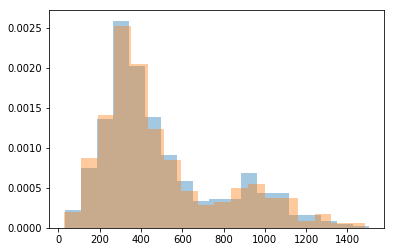

In [29]:
# Visualizing the prediction distribution and the test set distribution
sns.distplot(y_hat,kde=False,norm_hist=True)
sns.distplot(y_test,kde=False,norm_hist=True)
print("Test set average   = ",np.average(y_test))
print("Prediction average = ",np.average(y_hat))

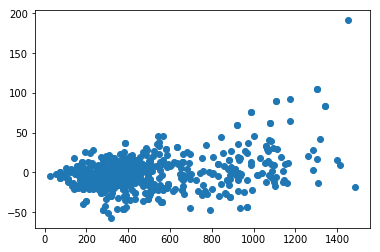

In [56]:
# Plotting the residuals to analyze the distribution of the MAE
plt.plot(y_test,residual,'o')

## Image quality impact plots

In [85]:
r2models = np.array([0.993951527865,0.993795848736,0.974668211139])
maemodels= np.array([15.9129888887,18.2847223225,35.0329371206])
quality  = np.array([30,20,10])

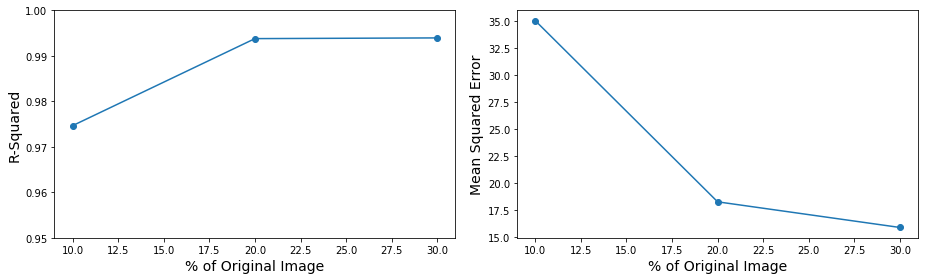

In [93]:
f, ax = plt.subplots(figsize=(13, 4))
plt.subplot(1,2,1)
plt.plot(quality,r2models,'o-')
plt.ylim(0.95,1.0)
plt.xlabel("% of Original Image",size=14)
plt.ylabel("R-Squared",size=14)


plt.subplot(1,2,2)
plt.plot(quality,maemodels,'o-')

plt.xlabel("% of Original Image",size=14)
plt.ylabel("Mean Squared Error",size=14)
plt.tight_layout()

plt.savefig('ImageSizeReductionAnalysis.png')